In [85]:
import os
import pandas as pd
import xml.etree.ElementTree as ET
from IPython.display import display
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [101]:
def plot_df(df, kind, x, y, xlabel, ylabel, color):
    
    plt.clf()
    
    # Define fig, ax
    fig, ax = plt.subplots(figsize=(10,6))

    # Make bar plot
    plot = df.plot(kind=kind, x=x, y=y, color=color, ax=ax)

    # Set labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Set legend
    legend = plt.legend()
    frame = legend.get_frame()
    frame.set_facecolor('white')

    return plot

In [46]:
parent_dir = 'LIBRARIES'

In [47]:
def retrieve_tracklist(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    main_dict=root.findall('dict')
    for item in list(main_dict[0]):    
        if item.tag=="dict":
            tracks_dict=item
            break
    tracklist=list(tracks_dict.findall('dict'))
    
    return tracklist

In [48]:
def create_lists(tracklist):
    purchased=[] # All purchased music
    apple_music=[] # Music added to lirary through subscription
    for item in tracklist:
        x=list(item)
        for i in range(len(x)):
            if x[i].text=="Kind" and x[i+1].text=="File audio AAC acquistato":
                purchased.append(list(item)) 
            if x[i].text=="Kind" and x[i+1].text=="File audio AAC Apple Music":
                apple_music.append(list(item))
    return purchased, apple_music

In [49]:
def cols(kind):
    cols=[]
    for i in range(len(kind)):
        for j in range(len(kind[i])):
            if kind[i][j].tag=="key":
                cols.append(kind[i][j].text)
    return set(cols)

In [50]:
def df_creation(kind,cols):
    df=pd.DataFrame(columns=cols)
    dict1={}
    df_list=[]
    for i, row in enumerate(kind):
        for j in range(len(row) - 1):
            if row[j].tag == "key":
                dict1[row[j].text] = row[j+1].text
        list_values=[i for i in dict1.values()]
        list_keys=[j for j in dict1.keys()]
        df_temp=pd.DataFrame([list_values],columns=list_keys)
        df_list.append(df_temp)
        
    df = pd.concat(df_list, axis=0, ignore_index=True, sort=True)
    return df

In [51]:
columns_of_interest=['track_id','song_name','play_count','skip_count','album','artist' \
 ,'genre','kind','persistent_id','year_of_release','play_date','skip_date',\
 'release_date','date_modified']

In [52]:
# Initiliaze an empty list to hold the dataframes
df_list = []

# Loop through each folder
for folder in os.listdir(parent_dir):
    folder_path = os.path.join(parent_dir, folder)
    if os.path.isdir(folder_path):
        year = int(folder)
    
        # Loop through each file in the folder
        for file in os.listdir(folder_path):
            if file.startswith("music_library_"):
                month = int(file.split("_")[2][4:6])
                print(f"Reading {month}-{year} library file")
                file_path = os.path.join(folder_path, file)
    
                tracklist = retrieve_tracklist(file_path)
                
                # Create apple_music and purchased lists:
                purchased, apple_music = create_lists(tracklist)
                
                # Define columns:
                purchased_cols = cols(purchased)
                apple_music_cols = cols(apple_music)
                
                # Create Pandas Dataframe:
                df_purchased = df_creation(purchased,purchased_cols)
                df_apple_music = df_creation(apple_music,apple_music_cols)
                
                # Create a single dataframe for purchased and apple music songs:
                temp_apple = df_apple_music.loc[:,['Track ID','Name','Play Count','Skip Count','Album',\
                    'Artist','Genre','Kind','Persistent ID','Year','Play Date UTC',\
                    'Skip Date','Release Date','Date Modified']]
                temp_purchased = df_purchased.loc[:,['Track ID','Name','Play Count','Skip Count', \
                    'Album','Artist','Genre','Kind','Persistent ID','Year',\
                    'Play Date UTC','Skip Date','Release Date','Date Modified']]
                df_songs = pd.concat([temp_purchased,temp_apple],axis = 0)
                df_songs.columns = columns_of_interest
                
                # Cast columns to appropriate datatypes
                df_songs[['track_id','play_count','skip_count','year_of_release']] = df_songs[['track_id',\
                    'play_count','skip_count','year_of_release']].apply(pd.to_numeric)
                df_songs[['play_date','skip_date','release_date','date_modified']] = df_songs[['play_date',\
                    'skip_date','release_date','date_modified']].apply(pd.to_datetime)
                
                # Create a month and year column (corresponding to the specific photograph of the Library)
                df_songs['year_libr'] = year
                df_songs['month_libr'] = month
                
                # Append the dataframe to the list
                df_list.append(df_songs)
                
                
# Concatenate all the dataframes into a single dataframe
df_library_history = pd.concat(df_list, ignore_index=True)

Reading 2-2023 library file


In [53]:
df_library_history.head(10)

,track_id,song_name,play_count,skip_count,album,artist,genre,kind,persistent_id,year_of_release,play_date,skip_date,release_date,date_modified,year_libr,month_libr
0,775,Intro,31,36,Fenomeno,Fabri Fibra,Hip Hop/Rap,File audio AAC acquistato,26F5FAF6CA27A142,2017,2021-10-20 07:02:47+00:00,2021-10-07 09:09:22+00:00,2017-04-07 07:00:00+00:00,2017-04-06 20:15:44+00:00,2023,2
1,777,Tutti Matti (Aquadrop Remix),99,9,Tradimento 10 Anni - Reloaded,Fabri Fibra,Hip Hop/Rap,File audio AAC acquistato,798DED70FD60F633,2006,2022-03-05 01:14:25+00:00,2022-02-19 00:42:57+00:00,2006-06-13 07:00:00+00:00,2016-07-02 07:56:52+00:00,2023,2
2,779,Red carpet,37,17,Fenomeno,Fabri Fibra,Hip Hop/Rap,File audio AAC acquistato,0AF1EA782BC1B4C4,2017,2021-10-20 07:06:23+00:00,2022-11-27 17:28:23+00:00,2017-04-07 07:00:00+00:00,2017-04-06 20:15:44+00:00,2023,2
3,781,Pamplona (feat. Thegiornalisti),73,48,Fenomeno,Fabri Fibra,Hip Hop/Rap,File audio AAC acquistato,8555A5C2D2F63C05,2017,2022-12-24 19:13:30+00:00,2022-12-04 17:34:43+00:00,2017-04-07 07:00:00+00:00,2017-04-06 20:15:44+00:00,2023,2
4,783,Skit - Il tempo vola,22,39,Fenomeno,Fabri Fibra,Hip Hop/Rap,File audio AAC acquistato,17880BA47A1D7B84,2017,2021-05-27 15:44:54+00:00,2021-10-20 07:09:51+00:00,2017-04-07 07:00:00+00:00,2017-04-06 20:15:44+00:00,2023,2
5,785,Fenomeno,23,39,Fenomeno,Fabri Fibra,Hip Hop/Rap,File audio AAC acquistato,D07C277271891E95,2017,2021-10-20 07:09:42+00:00,2023-01-05 10:18:11+00:00,2017-04-07 07:00:00+00:00,2017-04-06 21:15:44+00:00,2023,2
6,787,Dexter (feat. Nitro & Salmo),9,13,Squallor,Fabri Fibra,Hip Hop/Rap,File audio AAC acquistato,76499C82CD64F711,2015,2021-02-13 11:22:00+00:00,2023-01-05 10:18:11+00:00,2015-04-07 07:00:00+00:00,2015-04-11 11:19:45+00:00,2023,2
7,789,Equilibrio,82,10,Fenomeno,Fabri Fibra,Hip Hop/Rap,File audio AAC acquistato,9C3B4DEF5CB10904,2017,2022-09-23 17:49:55+00:00,2022-02-10 16:17:42+00:00,2017-04-07 07:00:00+00:00,2017-04-06 21:15:44+00:00,2023,2
8,791,Le vacanze (Big Fish Remix),7,9,Fenomeno (Masterchef EP),Fabri Fibra,Hip Hop/Rap,File audio AAC acquistato,21560D45DC7878EE,2017,2020-09-12 11:29:59+00:00,2019-04-30 04:41:41+00:00,2017-11-17 08:00:00+00:00,2017-11-17 20:06:33+00:00,2023,2
9,793,Skit - Considerazioni (feat. Roberto Saviano),17,27,Fenomeno,Fabri Fibra,Hip Hop/Rap,File audio AAC acquistato,2A5385851C474657,2017,2020-01-16 22:52:24+00:00,2020-09-24 11:56:20+00:00,2017-04-07 07:00:00+00:00,2017-04-06 20:15:44+00:00,2023,2


In [64]:
# Replacing different words for "Rap" genre with "Hip-Hop":
replacements = {'Hip Hop/Rap': 'Hip-Hop/Rap', 
                'Hip Hop': 'Hip-Hop/Rap',
                'Hip-Hop': 'Hip-Hop/Rap'
               
               }
df_library_history['genre'] = df_library_history['genre'].replace(replacements)

## Analysis of a single Month

In [65]:
# Time variable definition:
year_analysis = 2023
month_analysis = 2

In [66]:
# Filter dataframe
df_month = df_library_history[(df_library_history['year_libr']==year_analysis) & (df_library_history['month_libr']==2)]

In [73]:
# Genre exploration
df_genres_count = df_month.groupby('genre')['play_count'].sum().to_frame().reset_index()

top10_genre = df_genres_count.sort_values(by='play_count', ascending=False).head(10)
display(top10_genre)

,genre,play_count
6,Hip-Hop/Rap,19824
11,Pop,3374
2,Dance,468
0,Alternative,440
13,R&B/Soul,299
20,West Coast Rap,166
9,Latin,140
8,J-Pop,80
15,Rock,80
17,Soundtrack,79


<Figure size 640x480 with 0 Axes>

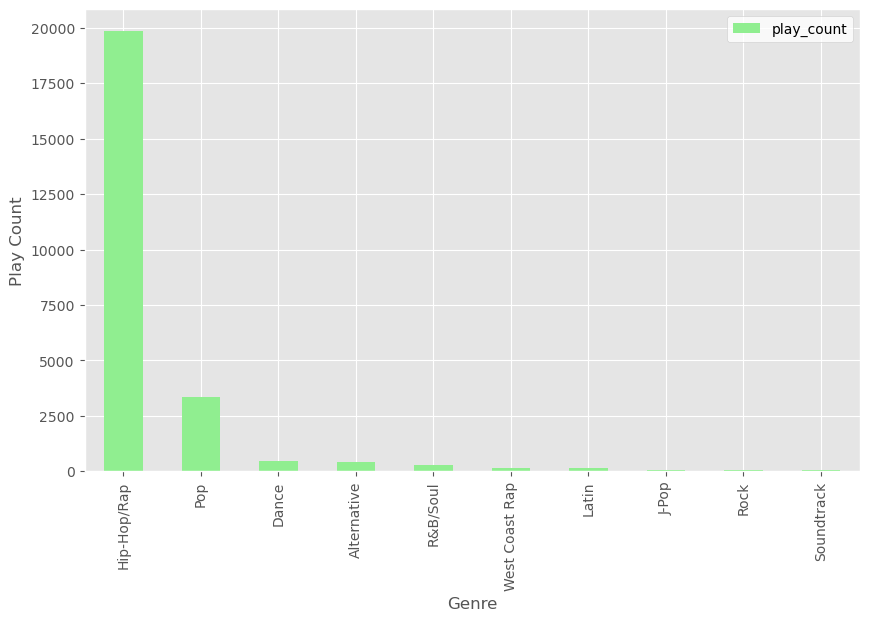

In [107]:
plot_genre = plot_df(top10_genre, 'bar', 'genre', 'play_count', 'Genre', 'Play Count', 'lightgreen')

In [97]:
# Top 15 artists
df_artist_count = df_month.groupby('artist')['play_count'].sum().to_frame().reset_index()
top15_artist= df_artist_count.sort_values(by='play_count', ascending=False).head(15)

display(top15_artist)

,artist,play_count
281,Lazza,2071
137,Fabri Fibra,2062
163,Future,1210
673,Vegas Jones,988
703,thasup,742
375,Marracash,713
239,Izi,627
160,Francesco Guccini,566
548,Salmo,550
94,Drake,538


<Figure size 640x480 with 0 Axes>

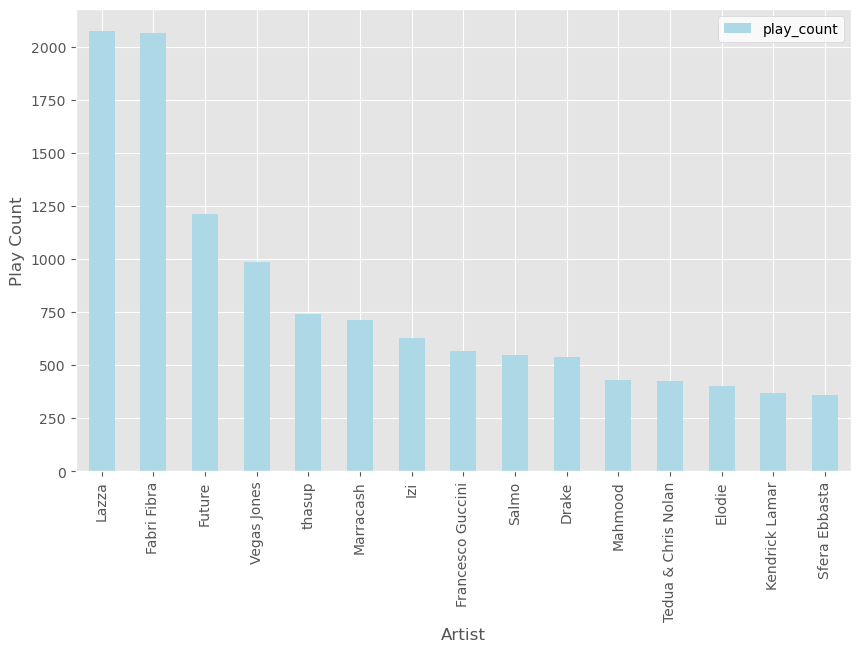

In [105]:
plot_artist = plot_df(top15_artist, 'bar', 'artist', 'play_count', 'Artist', 'Play Count', 'lightblue')